<a href="https://colab.research.google.com/github/Sung-Minsoek/Lego-Disassembler/blob/main/colab/Lego_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /path/to/your/directory

## Init


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import time

import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2

from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary

from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import math
from functools import partial
from sklearn.model_selection import train_test_split

random.seed(10)
np.random.seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


cuda


In [ ]:
data_path = 'data/data_GPT/data_GPT.npy' # path to data_GPT.npy
labels_path = 'data/data_GPT/labels_GPT.csv' # path to labels_GPT.npy

In [ ]:
params = {
    'optimizer'     : None,
    'loss_function' : None,
    'scheduler'     : None,
    'stats'         : [[0.5], [0.25]],
    'batch_size'    : 64,
    'worker'        : 4,
    'epochs'        : 50,
    'momentum'      : 0.9,
    'wd_decay'      : 0.0005,
    'lr'            : 0.0002,
    'train_size'    : 0.9,
    'valid_size'    : 0.1,
    'milestones'    : [],       # For Step lr scheduler
    'dropout'       : 0.5,      # For Dropout
    'patience'      : 10,       # For Early Stopping
    'device'        : 'cuda'    # 'cuda' = use cuda
}

## Data Load

In [ ]:
data = np.load(data_path)

In [ ]:
# data = np.transpose(data, (0, 2, 1, 3, 4))

In [ ]:
labels_df = pd.read_csv(labels_path)

In [ ]:
data = torch.from_numpy(data)

In [ ]:
data[data == 45] = 0

In [ ]:
labels = np.array(labels_df.values[:,1:])
labels = labels.astype(np.float32)
labels = torch.from_numpy(labels)

In [ ]:
labels_tensor = labels
print(labels_tensor)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
index_list = []

for row in labels:
    indices = torch.nonzero(row).squeeze().tolist()
    index_list.append(indices)

labels_tensor = torch.tensor(index_list)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None, no_labels=False):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.no_labels = no_labels

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        if self.no_labels == True:
            image = self.data[idx]
            if self.transform:
                image = self.transform(image)

            return image

        else:
            image = self.data[idx]
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

In [ ]:
train_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=False),
    v2.RandomHorizontalFlip(),
    v2.RandomCrop((224, 224), padding=16),
    # v2.RandomRotation(30),
    v2.ToDtype(torch.float32),
    v2.Normalize((0.45,), (0.225,))
])

valid_transforms = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize((0.45,), (0.225,))
])

In [ ]:
dataset_size = len(data)
trainset_size = int(dataset_size * params['train_size'])
validset_size = int(dataset_size * params['valid_size'])

In [ ]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels_tensor, test_size=params['valid_size'], random_state=10)

In [ ]:
train_dataset = CustomDataset(train_data, train_labels, transform=train_transforms)
trainloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['worker'])

valid_dataset = CustomDataset(valid_data, valid_labels, transform=valid_transforms)
validloader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['worker'])

## Show Image

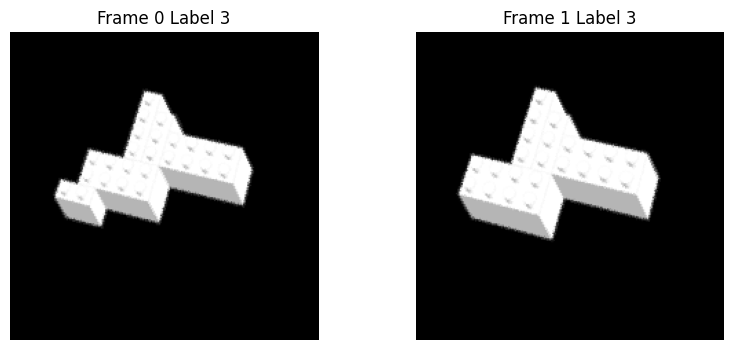

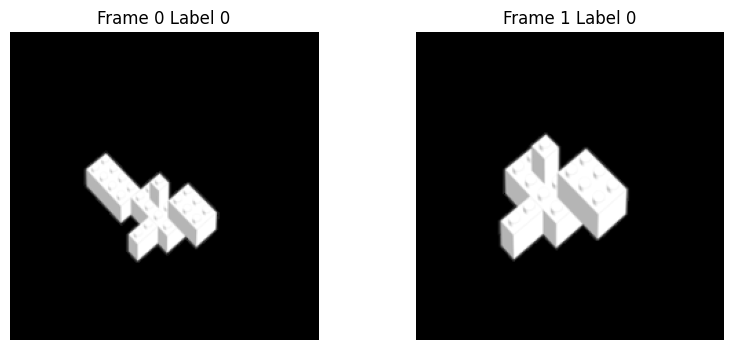

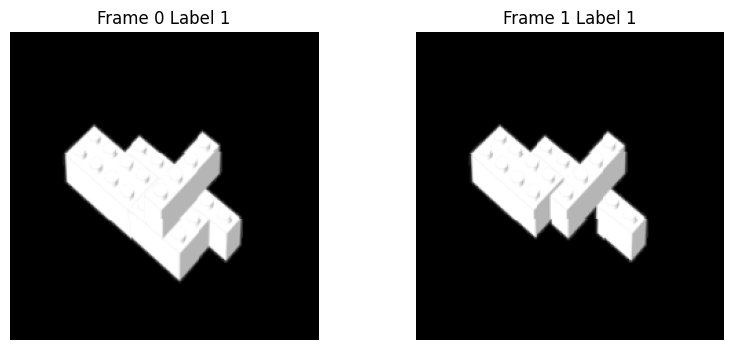

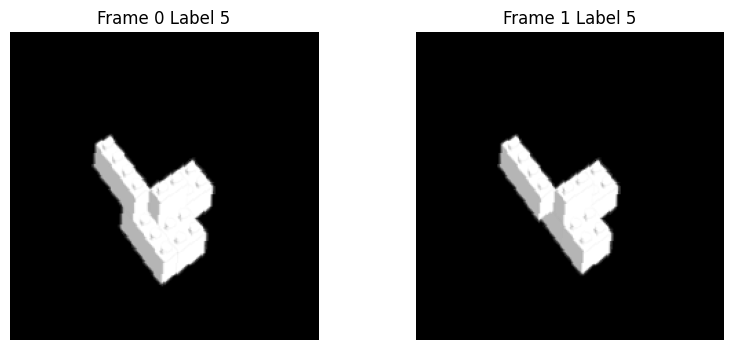

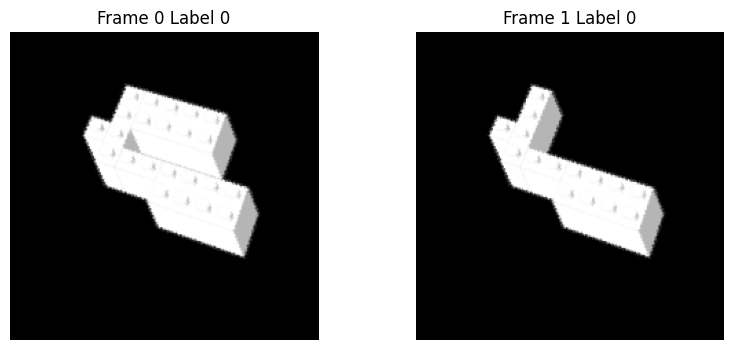

In [ ]:
dataiter = iter(trainloader)
videos, labels = next(dataiter)

for i in range(5):
    video = videos[i, 0, :, :, :]
    label = labels[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.1)

    frame1 = video[0, :, :]
    frame2 = video[1, :, :]

    axes[0].imshow(frame1.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Frame {0} Label {label}')

    axes[1].imshow(frame2.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'Frame {1} Label {label}')

    plt.show()

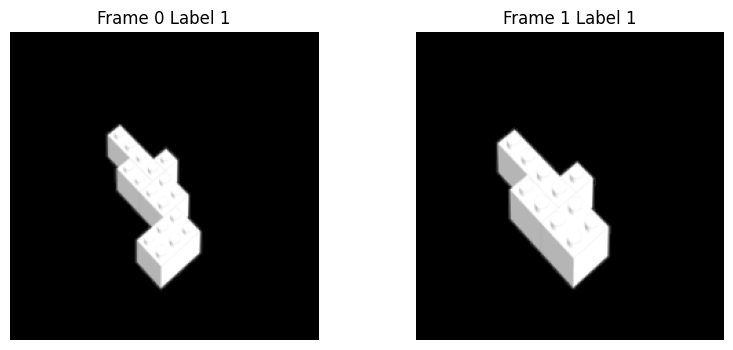

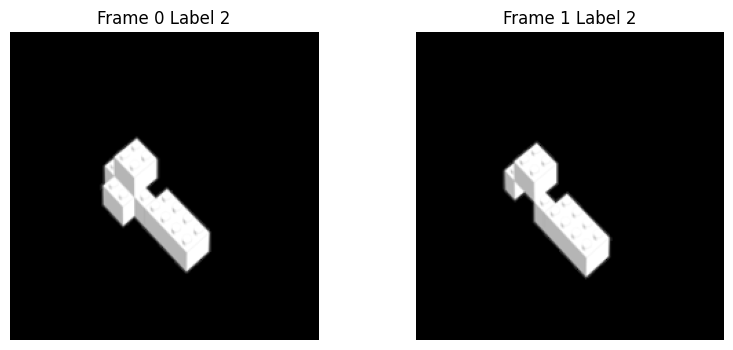

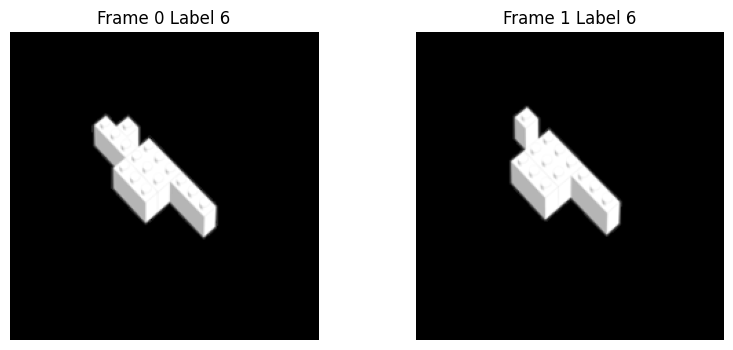

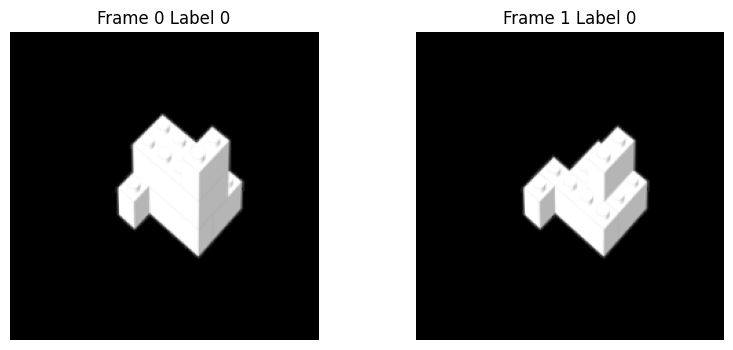

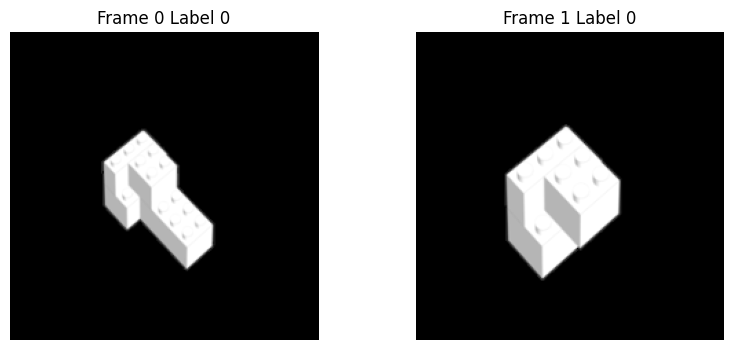

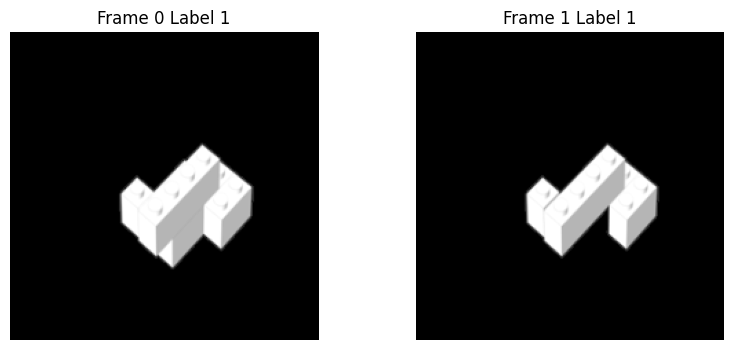

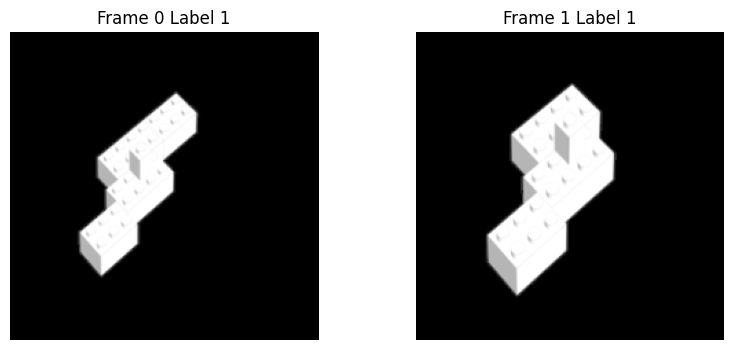

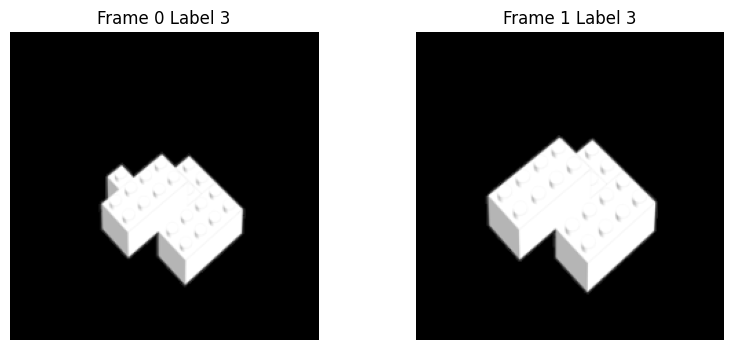

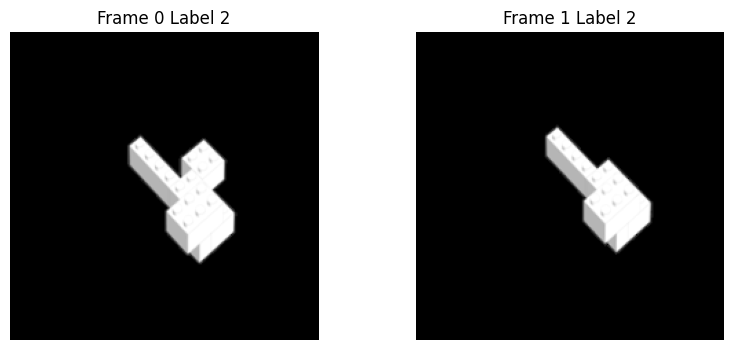

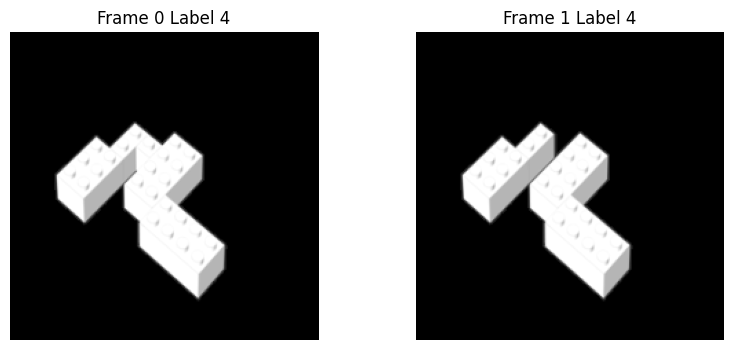

In [ ]:
dataiter = iter(temploader)
videos, labels = next(dataiter)

for i in range(10):
    video = videos[i, 0, :, :, :]
    label = labels[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.1)

    frame1 = video[0, :, :]
    frame2 = video[1, :, :]

    axes[0].imshow(frame1.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Frame {0} Label {label}')

    axes[1].imshow(frame2.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'Frame {1} Label {label}')

    plt.show()

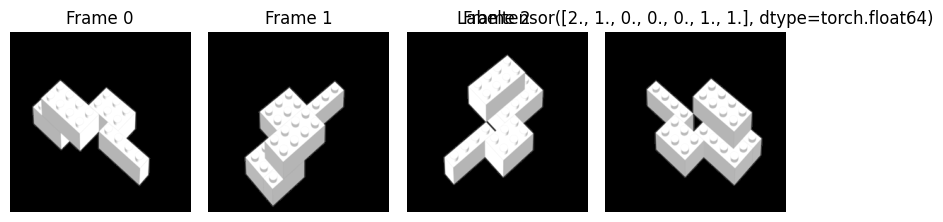

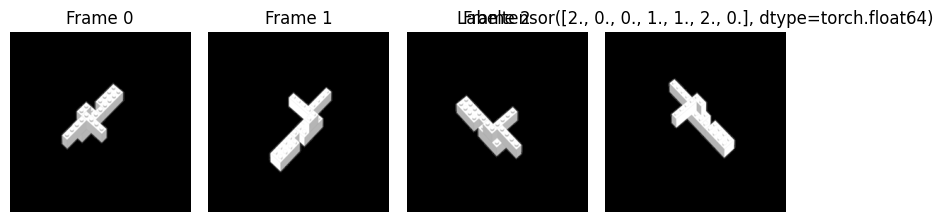

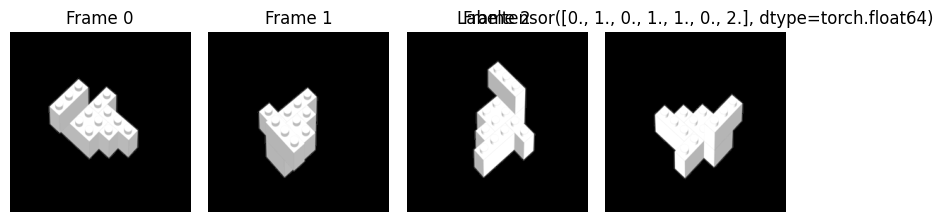

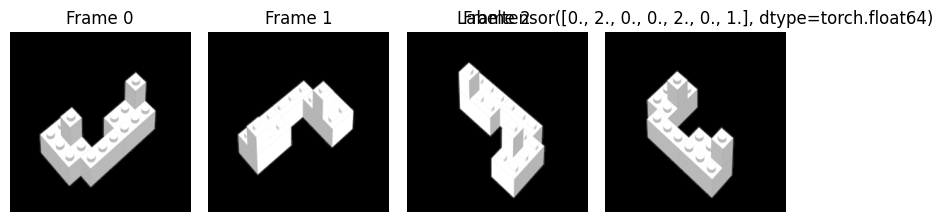

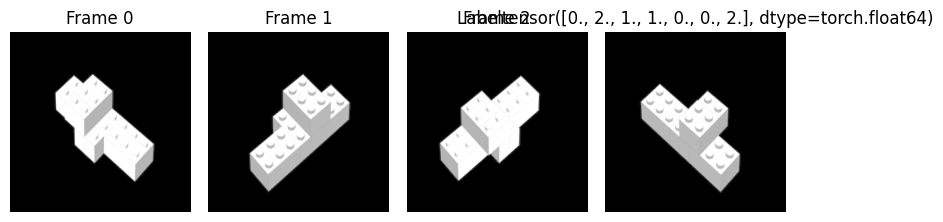

In [ ]:
dataiter = iter(trainloader)
videos, labels = next(dataiter)

for i in range(5):
    video = videos[i, 0, :, :, :]
    label = labels[i]

    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.1)

    for f in range(4):
        frame = video[f, :, :]

        axes[f].imshow(frame.squeeze(), cmap='gray')
        axes[f].axis('off')
        axes[f].set_title(f'Frame {f}')

    plt.title(f'Label{label}')
    plt.show()

## ResNet-3D

In [ ]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=(1, stride, stride),
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=(1, stride, stride),
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=3,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=7):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(params['dropout'])
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

## Model Test

In [ ]:
model = generate_model(50)
model = model.to(device)

In [ ]:
summary(model, (1, 2, 256, 256))

## Train

In [ ]:
train_accs = []
valid_accs = []

In [ ]:
params['loss_function'] = nn.CrossEntropyLoss(label_smoothing=0.1)
params['optimizer'] = optim.AdamW(params=model.parameters(), lr = params['lr'], weight_decay=params['wd_decay'])
params['scheduler'] = optim.lr_scheduler.OneCycleLR(params['optimizer'], params['lr'], total_steps=params['epochs'] * len(trainloader))

In [ ]:
def test_with_labels_for_classification(model, testloader):
    val_correct = 0
    val_total = 0

    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    return val_correct / val_total

In [ ]:
def train(model, trainloader, validloader, params):
    best_valid_acc = 0
    train_total = 0
    train_correct = 0

    device = params['device']

    optimizer = params['optimizer']
    criterion = params['loss_function']
    scheduler = params['scheduler']

    model.train()

    for epoch in range(params['epochs']):
        running_loss = 0.0
        num_samples = 0

        start_time = time.time()

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # 4차원 텐서에만 사용
            # inputs = inputs.to(memory_format=torch.channels_last)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast(True):
                output = model(inputs)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            num_samples += inputs.size(0)

            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #Time
            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')

        valid_acc = test_with_labels_for_classification(model, validloader)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc

            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': params['optimizer'].state_dict(),
                'scheduler_state_dict': params['scheduler'].state_dict(),
            }

            torch.save(checkpoint, '성민석/Lego-GPT Data/best_model.pth')

        train_accs.append(train_correct / train_total * 100)
        valid_accs.append(valid_acc * 100)

        print('Epoch: {}/{}, train_acc: {:.2f}%, valid_acc: {:.2f}%, time:{}m {}s'.format(epoch + 1, params['epochs'], train_correct / train_total * 100, valid_acc * 100, time_taken[0], time_taken[1][:2]))

    return model

In [ ]:
model = train(model, trainloader, validloader, params)

## Result visualize

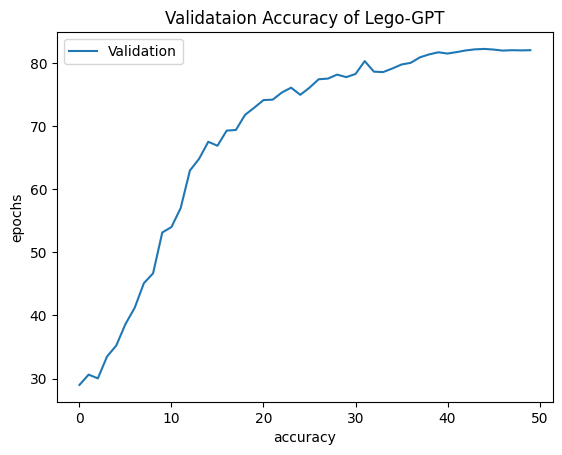

In [ ]:
plt.plot(valid_accs, label='Validation')

plt.title('Validataion Accuracy of Lego-GPT')
plt.xlabel('accuracy')
plt.ylabel('epochs')

plt.legend()
plt.show()

In [ ]:
def show_prediction_with_img(probs, preds, ys, imgs):
    probs = probs.detach().cpu()
    preds = preds.detach().cpu()
    ys = ys.detach().cpu()

    column = 4
    total = len(probs) * 2
    row = total // column
    plt.figure(figsize=(25, 3 * total // 2))

    idx = 1
    for b in range(len(probs)):
        color = ['r' if i else 'b' for i in (preds[b] == ys[b]).tolist()]
        label = [classes(i) for i in preds[b].tolist()]

        plt.subplot(row, column, idx)
        plt.imshow(imgs[b])
        plt.axis('off')
        plt.gca().set_title(classes(ys[b]))
        idx += 1

        plt.subplot(row, column, idx)
        plt.bar([], probs[b], color=color)
        plt.xticks(rotation=20)
        idx += 1
    plt.show()

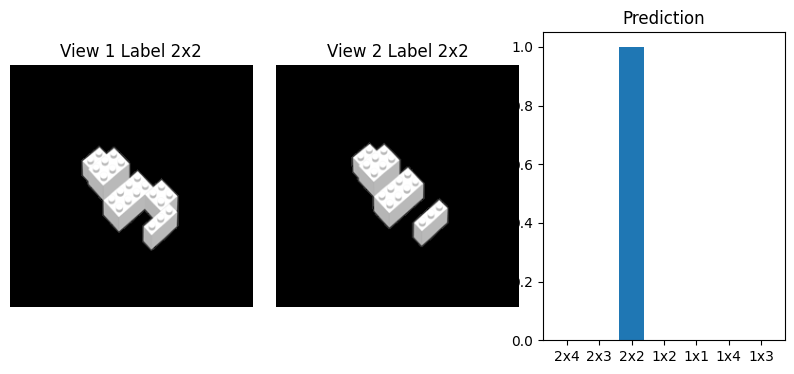

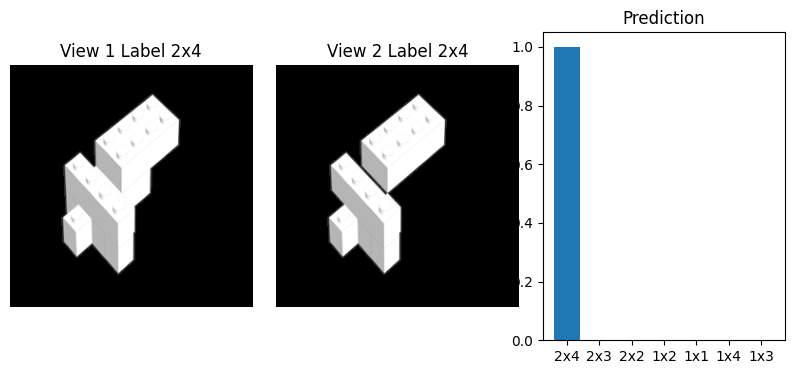

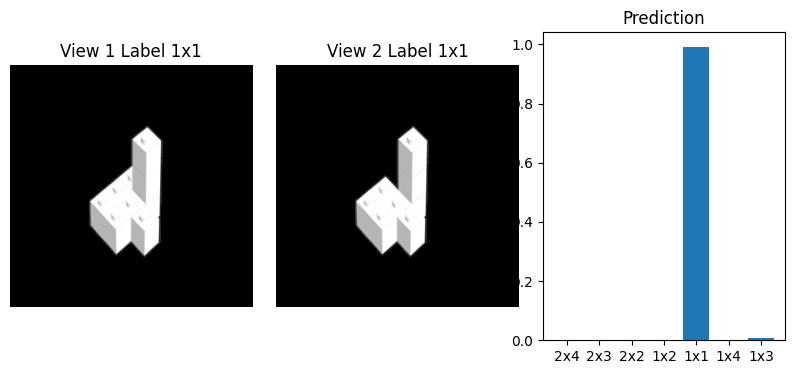

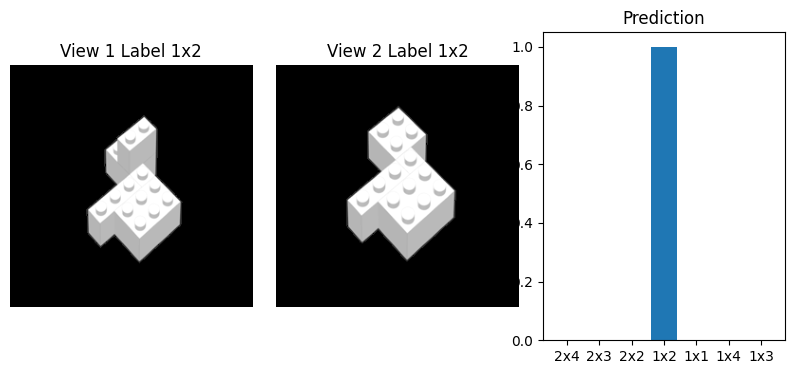

In [ ]:
valid_dataset = CustomDataset(valid_data, valid_labels, transform=valid_transforms)
validloader = DataLoader(valid_dataset, 4, shuffle=True, num_workers=params['worker'])

dataiter = iter(validloader)
videos, labels = next(dataiter)

classes = ['2x4', '2x3', '2x2', '1x2', '1x1', '1x4', '1x3']

for i in range(4):
    video = videos[i, 0, :, :, :]
    label = labels[i]

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.1)

    frame1 = video[0, :, :]
    frame2 = video[1, :, :]

    axes[0].imshow(frame1.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'View {1} Label {classes[label]}')

    axes[1].imshow(frame2.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'View {2} Label {classes[label]}')

    logit = model(videos.to(params['device']))
    prob = F.softmax(logit, dim=1)
    prob = prob.detach().cpu().squeeze().tolist()

    axes[2].bar(classes, prob[i])
    axes[2].set_title(f'Prediction')

    plt.show()